In [1]:
!pip install qiskit matplotlib

Latex commands are defined in this cell
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\renewcommand{\qed}{\hfill\blacksquare}$$
$$\newcommand{\paulix}{\begin{bmatrix} 0 && 1 \\ 1 && 0\end{bmatrix}}$$
$$\newcommand{\pauliy}{\begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix}}$$
$$\newcommand{\pauliz}{\begin{bmatrix} 1 && 0 \\ 0 && -1\end{bmatrix}}$$

# My solutions to exercises and problem sets from "Quantum Computation and Quantum Information"

## Exercises for Chapter 1

### Exercise 1.1 (page 36): (Probabilistic classical algorithm)

Given $n$ bits, the function $f(x)$ has a domain of size $2^n$. The best classical deterministic algorithm, in the worst case, must check half of all inputs + 1 (that is, $2^n/2 + 1= 2^{n-1}+1$).

Consider the probabilistic solution where we do $k$ unique evaluations of the $f(x)$ for unique and randomized $x \in \{0,1\}^n$. If any samples differ from the rest of the samples, we conclude $f(x)$ is balanced, otherwise we conclude it is constant.

If $f(x)$ is constant, we will be correct with probability 1. If $f(x)$ is balanced, for the case $k = 2$, there are only 4 possible sampling outcomes: $f(x_1) \otimes f(x_2)\in \{00, 01, 10, 11\}$. The probability of getting all equal outputs, that is $f(x_1) \otimes f(x_2) \in \{00, 11\}$ is $\frac{2^{n-1} - 1}{2^n - 1}$, so we will be incorrect with that probability. For n = 2 its 1/3. In the limit as n approaches infinity, this approaches 1/2

In general, given $n, k$, the prob of getting all equal outputs, that is $f(x_1) \otimes f(x_2) \otimes ... \otimes f(x_k) \in \{0^k, 1^k\}$ has probability $\prod_{i=1}^k \frac{2^{n-1} - k}{2^n - k}$, so we will be incorrect with that probability. For n = 2 its 1/3. In the limit as n approaches infinity, this approaches 1/2

So to answer the question posed by the exercise, the performance of the best classical algorithm for the Deutsch-Jozsa problem is $\mathcal{O}(1)$, since we can get better than $\epsilon < 1/2$ with $ k = 2 $ for any n

In [2]:
def epsilon(n, k):
    """
    Given the number of bits n and number of samples k, calculate the prob of the above
    algorithm being incorrect if f(x) is balanced
    """
    result = k
    for x in range(k):
        result *= (2**(n-1)-x)/(2**n - x)
    return result

epsilon(50, 2)

0.49999999999999956

### Exercise 1.2 (page 57): (Cloning and Distinguishability)

#### Cloning given Distinguishability

Given a circuit that can distinguish between non-orthogonal states: $$\ket{\Psi} = e^{i\gamma}(\cos\frac{\theta}{2}\ket{0} +e^{i\phi}\sin\frac{\theta}{2}\ket{1})$$

$$\ket{\Phi} = e^{i\gamma^{\prime}}(\cos\frac{\theta^{\prime}}{2}\ket{0} +e^{i\phi^{\prime}}\sin\frac{\theta^{\prime}}{2}\ket{1})$$

We can build a quantum cloning given below. Note we do this for 1 qubit, but the same procedure can be applied to an n-qubit register

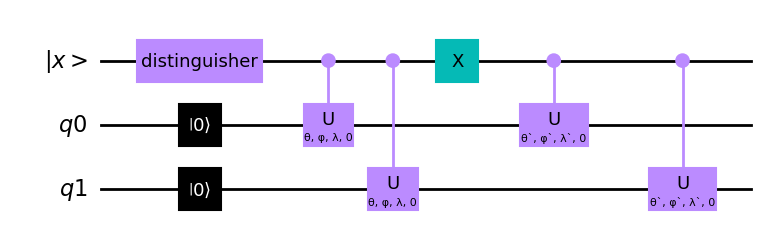

In [3]:
from qiskit import *
from qiskit.circuit import Parameter
from math import pi

# Psi
psi_theta = Parameter('θ')
psi_phi = Parameter('φ')
psi_lambda = Parameter('λ')

# Phi
phi_theta = Parameter('θ`')
phi_phi = Parameter('φ`')
phi_lambda = Parameter('λ`')

# Define our distinguisher oracle
distinguisher = QuantumCircuit(1, name="distinguisher")
distinguisher.to_instruction()

x_qubit = QuantumRegister(1, '|x>')
scratch0 = QuantumRegister(1)
scratch1 = QuantumRegister(1)

circuit = QuantumCircuit(x_qubit, scratch0, scratch1)
circuit.append(distinguisher,[0])
circuit.reset(1)
circuit.reset(2)
circuit.cu(psi_theta, psi_phi, psi_lambda, 0, 0, 1)
circuit.cu(psi_theta, psi_phi, psi_lambda, 0, 0, 2)
circuit.x(0)
circuit.cu(phi_theta, phi_phi, phi_lambda, 0, 0, 1)
circuit.cu(phi_theta, phi_phi, phi_lambda, 0, 0, 2)
circuit.draw(output='mpl')

Conversely, given a cloning circuit we may distinguish between two states with high probability by repeatedly cloning our state and measuring it in the $\ket{\Psi}$ basis a large amount of times. If we measure -1 even once, then we output 0, indicating the original state is $\ket{\Phi}$, otherwise we output 1, indicating  $\ket{\Psi}$. Note in the below circuit, the inverted U Gate is the adjoint of the above gate. This is just to effectively measure in the $\ket{0}$ basis

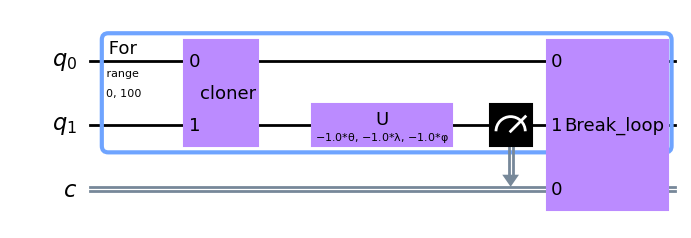

In [4]:
from qiskit.circuit.library import UGate

qc = QuantumCircuit(2, 1)

cloner = QuantumCircuit(2, name="cloner")
cloner.to_instruction()

N=100 # The larger the N, the higher the certainty in the result
with qc.for_loop(range(N)) as i:
    qc.append(cloner, [0,1])
    qc.append(UGate(psi_theta, psi_phi, psi_lambda).inverse(), [1]) # Bring from phi-basis to 0-basis
    qc.measure(1, 0)
    qc.break_loop().c_if(0, 0)
qc.draw(output='mpl')

## Exercises for Chapter 2

### Exercise 2.1 (page 63): (Linear dependence)

Show that the vectors below are linearly dependent

$$v_1 = \begin{bmatrix} 1 \\ -1 \end{bmatrix}, v_2 = \begin{bmatrix} 1 \\ 2 \end{bmatrix}, v_3 = \begin{bmatrix} 2 \\ 1 \end{bmatrix}$$

Recall that N vectors $v_1, v_2, ... v_N$ are lineraly-dependent if there exists $a_1, a_2, ..., a_N$ such that $\sum_{i=1}^N{a_iv_i} = 0$, where at least one $a_i \ne 0$

Clearly this is the case for $a_1 = 1, a_2 = 1, a_3 = -1$


### Exercise 2.2 (page 64): (Matrix representation)
Given a linear operator $A$ which maps $\ket{0}$ to $\ket{1}$ and vice-versa, the matrix representation of $A$ in the basis $\ket{0}$ and $\ket{1}$ for both the input and output vector spaces is
$$A = \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix}$$

To find $A$ for different input and output basis, say $\ket{+}$ and $\ket{-}$, we can simply find the matrix $S$ which transforms from the ($\ket{+}$, $\ket{-}$) basis to the ($\ket{0}$, $\ket{1}$).

Trivially, this is $$ S = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 && 1\\ 1 && -1\end{bmatrix}$$

We may then construct the matrix $A^\prime = S^{\dagger}AS$

### Exercise 2.3 (page 64): (Matrix representation for operator products)
Show the matrix representation for linear transformation $BA$ is the matrix product of the matrix representation for $B$ and $A$, with respect to the approriate bases.

$$A: V \rightarrow W$$
$$B: W \rightarrow X$$

$V$, $W$, and $X$ have basis vectors $\ket{v_i}$, $\ket{w_j}$, and $\ket{x_k}$ respectively, such that

$$A\ket{v_i} = \sum_j{A_{ji}\ket{w_j}}$$
$$B\ket{w_j} = \sum_k{B_{kj}\ket{x_k}}$$

therefore
$$ BA\ket{v_i} = B(A\ket{v_i}) = B(\sum_j{A_{ji}\ket{w_j}}) = \sum_j{A_{ji}B\ket{w_j}} = \sum_j{A_{ji}\sum_k{B_{kj}\ket{x_k}}} = \sum_k{\ket{x_k}\sum_j{B_{kj}A_{ji}}} = \sum_k{BA_{ki}\ket{x_k}}$$

where

$$ BA_{ki} = \sum_j{B_{kj}A_{ji}}$$

which is the matrix product of $B$ and $A$ by definition

### Exercise 2.4 (page 65): (Matrix representation for identity)
Show the identity operator $I: V \rightarrow V$ has a matrix representation of $\delta_{ij}$ when acting on the same input and output basis

The matrix representation of $I$ is one that satisfies:

$$I\ket{v_j} = \sum_i{I_{ij}\ket{v_i}}=I_{jj}\ket{v_j} + \sum_{i \ne j}{I_{ij}\ket{v_i}}$$

Because the vectors $\ket{v_i}$ are linearly-independent and so any combination of non-$\ket{v_j}$ vectors may not contribute to along the $\ket{v_j}$ direction, $I_{jj} = 1$. The remaining terms must be zero, which we prove by contradiction:

If $I_{ij} \ne 0$ for $i \ne j$, then 

$$\sum_{i \ne j}{I_{ij}\ket{v_i}} = 0$$

or equivalently, for $I_k \ne 0$, 

$$\sum_{k}{I_{k}\ket{v_k}} = 0$$

which implies $\ket{v_k}$ are linearly dependent. Therefore, $I_{ij} = \delta_{ij}$


### Exercise 2.5 (page 66): (Verify (.,.) is an inner product on $\bf{C^n}$)

The three requirements of an inner product $(a, b)$ are:
1. $(a, \alpha b + \beta c) = \alpha(a, b) +\beta (a, c)$ (that is, linear in its second argument)
2. $(a, b) = (b, a)^*$
3. $(a, a) \ge 0 $ with equality iff $a = 0$


Verify these are met for the inner product on $\bf{C^n}$ defined as:
$$ ((y_1,...,y_n),(z_1,...,z_n)) = \sum_i{y_i^*z_i} = \begin{bmatrix} y_1^* \ ... \ y_n^* \end{bmatrix} \begin{bmatrix} z_1 \\ \vdots \\ z_n \end{bmatrix} $$

1. $(a, \alpha b + \beta c) =  \sum_i{a_i^*(\alpha b_i + \beta c_i)} = \sum_i{a_i^*\alpha b_i + a_i^*\beta c_i} = \alpha \sum_i{a_i^*b_i} + \beta \sum_i{a_i^*c_i} = \alpha(a, b) + \beta (a, c)$

2. $(a, b) = \sum_i{a_i^*b_i} = (\sum_i{b_i^*a_i})^* = (b, a)^*$

3. $(a, a) = \sum_i{a_i^*a_i} = \sum_i{|a_i|^2}$ (finite sum of positive numbers is always positive)


### Exercise 2.6 (page 66): (Verify any (.,.) is conjugate-linear in first argument)

Prove $$(\alpha a + \beta b, c) = \alpha^* (a, c) + \beta^* (b, c)$$

By point 2: $$(\alpha a + \beta b, c) = (c, \alpha a + \beta b)^*$$

By point 1: $$(c, \alpha a + \beta b)^* =  (\alpha (c, a) + \beta (c, b))^* = \alpha^* (c, a)^* + \beta^* (c, b)^*$$

By point 2: $$\alpha^* (c, a)^* + \beta^* (c, b)^* = \alpha^* (a, c) + \beta^* (b, c)$$

### Exercise 2.7 (page 66): (Verify orthogonality of $\ket{w} = (1,1)$ and $\ket{v} = (1, -1)$)

Also show the normalized versions.

$$(\ket{w}, \ket{v}) = \begin{bmatrix} 1^* \ 1^* \end{bmatrix} \begin{bmatrix} 1 \\ -1 \end{bmatrix} = 0$$


$$ \frac{\ket{w}}{||\ket{w}||} = \frac{\ket{w}}{\sqrt{\braket{w}{w}}} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} $$

$$ \frac{\ket{v}}{||\ket{v}||} = \frac{\ket{v}}{\sqrt{\braket{v}{v}}} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ -1 \end{bmatrix} $$


### Exercise 2.8 (page 66): (Prove Gram-Schmidt produces an orthonomral basis for V)

$$\ket{v_{k+1}} = \frac{\ket{w_{k+1}} -\sum_{i=1}^{k}{\braket{v_i}{w_{k+1}} \ket{v_i}}}{|| \ket{w_{k+1}} - \sum_{i=1}^{k}{\braket{v_i}{w_{k+1}} \ket{v_i}} ||} $$

We prove the above by induction. Base case:

$$\ket{v_1} = \frac{\ket{w_1}}{|| \ket{w_1} ||}$$

It is trivially unit length and linearly-independent.

Inductive step: Assume $\{\ket{v_i}: i < k\}$ for $i < k$ is an orthonormal basis, we show $\{\ket{v_i}: i \le k\}$ is also an orthonormal basis:


It is trivial to see $\ket{v_{k+1}}$ is of unit length, as the vector is scaled by the reciprocal of its length. Therefore all we have to do is show orthogonality with all other vectors in the basis, so we ignore the normalization factor:

$$\ket{v_{k+1}}  \propto \ket{w_{k+1}} -\sum_{i=1}^{k}{\braket{v_i}{w_{k+1}} \ket{v_i}}$$

And so 

$$\braket{v_j}{v_{k+1}} \propto \braket{v_j}{w_{k+1}} -\sum_{i=1}^{k}{\braket{v_i}{w_{k+1}} \braket{v_j}{v_i}} $$

$$\braket{v_j}{v_{k+1}} \propto \braket{v_j}{w_{k+1}} -\sum_{i=1}^{k}{\braket{v_i}{w_{k+1}} \delta_{ji}}$$

$$\braket{v_j}{v_{k+1}} \propto \braket{v_j}{w_{k+1}} -\braket{v_j}{w_{k+1}}$$

$$\braket{v_j}{v_{k+1}} \propto 0$$

$$\braket{v_j}{v_{k+1}} = 0$$

### Exercise 2.9 (page 68): (Pauli Operators and Outer Product)

Express all 4 Pauli matrices ($\sigma_0$, $\sigma_1$, $\sigma_2$, $\sigma_3$) in the outer product  with respect to the ($\ket{0}$, $\ket{1}$) basis:

$$I = \sum_{i=0}^1{\ket{i} \bra{i}}$$

$$\sigma_i = I\sigma_kI = \sum_{ij}{\bra{j} \sigma_k \ket{i} \ket{j} \bra{i}}$$ 

$$\sigma_0 = \sum_{ij}{\bra{j} \sigma_0 \ket{i} \ket{j} \bra{i}} = \sum_{ij}{\delta_{ij} \ket{j} \bra{i}} = \sum_{i}{\ket{i} \bra{i}}$$

$$\sigma_1 = \sum_{ij}{\bra{j} \sigma_1 \ket{i} \ket{j} \bra{i}} = \sum_{ij}{\ket{j} \bra{i}}$$ 

$$\sigma_2 = \sum_{ij}{\bra{j} \sigma_2 \ket{i} \ket{j} \bra{i}} = \sum_{ij}{(-1)^ii \ket{j} \bra{i}}$$ 

$$\sigma_3 = \sum_{ij}{\bra{j} \sigma_3 \ket{i} \ket{j} \bra{i}} = \sum_{ij}{(-1)^i\delta_{ij} \ket{j} \bra{i}} = \sum_{i}{(-1)^i \ket{i} \bra{i}}$$ 





### Exercise 2.10 (page 68):

Suppose $\ket{v_i}$ is an orthonormal basis. What is the martix representation for the operator $A = \ket{v_j}\bra{v_k}$


$\ket{v_j}\bra{v_k}$ maps $\ket{v_i}$ to $0$ if $i \ne k$, otherwise it is mapped to $\ket{v_j}$. This means all columns are $0$ if  $i \ne k$, otherwise, for the $i = k$ case, we have the matrix representation of $\ket{v_j}$

$$A\ket{v_i} = \ket{v_j}\braket{v_k}{v_i} = \sum_{l}{A_{li}\ket{v_l}} = \ket{v_j}\delta_{ki}$$

That is $A_{jk} = 1$ and $A_{ab} = 0$ otherwise.





### Exercise 2.11 (page 69): (Eigendecomposition of Pauli matrices)

Find the eigenvectors, eigenvalues, and diagonal representation of the Pauli matrices.

In Exercise 2.9 we calculated:

$$\sigma_0 = \sum_{i}{\ket{i} \bra{i}} = \sum_{i}{\lambda_i \ket{i} \bra{i}}, \lambda_i = 1$$

$$\sigma_3 = \sum_{i}{\lambda_i \ket{i} \bra{i}}, \lambda_i = (-1)^i$$ 

Recall $\ket{+} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}$ and $\ket{-} = \frac{\ket{0} - \ket{1}}{\sqrt{2}}$

$$\sigma_1 = \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix}$$

Clearly, $\ket{+}$, $\ket{-}$ are eigenvectors with respective eigenvalues $\lambda = 1$ and $\lambda = -1$, so $$\sigma_1 = \ket{+} \bra{+} - \ket{-} \bra{-}$$


$$\sigma_2 = \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix}$$

To find the eigenvalues $\lambda$ and eigenvectors $v$, we want:

$$\sigma_2 v = \lambda v = \lambda I v$$

$$ (\sigma_2 - \lambda I)v = 0 $$

In order for there to be non-trivial solutions to this, $(\sigma_2 - \lambda I)$ must be non-full-rank (a.k.a singular), because full-rank matrices only have a trivial kernel, and therefore its determinant must be zero, because they "squash" at least one dimension so the way they transform areas, volumes, etc...

$$det(\sigma_2 - \lambda I) = \begin{vmatrix} -\lambda && -i\\ i && -\lambda\end{vmatrix} = \lambda^2 -1 = 0$$, therefore $\lambda =\pm 1$
. To find the eigenvectors, we must find the kernel of the matrix which we do using rref $$\begin{bmatrix} -\lambda && -i\\ i && -\lambda\end{bmatrix} \rightarrow \begin{bmatrix} -\lambda i && 1\\ 0 && 0\end{bmatrix}$$


therefore the eigenvectors for this are $$ \begin{bmatrix} 1 \\ \lambda i \end{bmatrix} $$ and the outer product rep is $\sigma_2 = \ket{a}\bra{a} - \ket{b}\bra{b}$ for $\ket{a} = \ket{0} + i \ket{1}$, $\ket{b} = \ket{0} - i \ket{1}$


### Exercise 2.12 (page 69):
Prove that the matrix $A = \begin{bmatrix} 1 && 0\\ 1 && 1\end{bmatrix}$ is not diagonalizable

The eigenvalue for this matrix is $1$ with an algebraic multiplicity of 2. Only $\begin{bmatrix} 0 \\ 1 \end{bmatrix}$ is an eigenvector, which means it is not diagonalizable, since we need an orthonormal basis made up of eigenvectors of $A$




### Exercise 2.13 (page 70):
Show $(\ket{w}\bra{v})^\dagger = \ket{v}\bra{w} = A^\dagger$

($\ket{a}$, $A\ket{b}$) = ($\ket{a}$, $\ket{w}\braket{v}{b}$) = ($\braket{w}{a}$, $\braket{v}{b}$) = ($\ket{v}\braket{w}{a}$, $\ket{b}$) = ($A^\dagger\ket{a}$, $\ket{b}$)




### Exercise 2.14 (page 70): (Anti-linearity of adjoint)
Show the adjoint operation is anti-linear. That is,

$$(\sum_{i}{a_iA_i})^\dagger = \sum_{i}{a_i^*A_i^\dagger}$$

($\ket{v}$, $(\sum_{i}{a_iA_i})\ket{w}$) = $\sum_{i}{a_i(\ket{v}, A_i\ket{w})}$ = $\sum_{i}{(a_i^*A_i^\dagger\ket{v}, \ket{w})}$ = ($(\sum_{i}{a_i^*A_i^\dagger})\ket{v}$, $\ket{w}$)

Note: for any scalar $a \in C$, $a^\dagger = a^*$

### Exercise 2.15 (page 70):
Show $(A^\dagger)^\dagger = A$

($\ket{a}$, $A\ket{b}$) = ($A^\dagger\ket{a}$, $\ket{b}$) = ($\ket{b}$, $A^\dagger\ket{a}$)$^*$ = ($(A^\dagger)^\dagger\ket{b}$, $\ket{a}$)$^*$ = ($\ket{a}$, $(A^\dagger)^\dagger\ket{b}$) $\rightarrow A = (A^\dagger)^\dagger$

### Exercise 2.16 (page 70):
Show any projector $P \equiv \sum_{i=1}^{k}{\ket{i}\bra{i}}$ satisfies the equation $P^2 = P$

$P^2 = (\sum_{i=1}^{k}{\ket{i}\bra{i}})(\sum_{j=1}^{k}{\ket{j}\bra{j}}) = \sum_{ij}{\ket{i}\delta_{ij}\bra{j}} = \sum_{i}{\ket{i}\bra{i}}$


### Exercise 2.17 (page 70):
Show that a normal matrix is Hermitian iff it has real eigenvalues.

Normal Matrix $A$ implies $A^\dagger A = A A^\dagger$.

By the spectral decomposition of normal matrices, $A$ is diagonalizable. That is $A = \sum_{i}{\lambda_i \ket{i}\bra{i}}$ for some eigenbasis $\ket{i}$:

$$A^\dagger = \sum_{i}{\lambda_i^* (\ket{i}\bra{i})^\dagger} = \sum_{i}{\lambda_i^* \ket{i}\bra{i}}$$

If the eigenvalues $\lambda_i$ are real, $\lambda_i^* = \lambda_i$, and $A$ is Hermitian:

$$A^\dagger = \sum_{i}{\lambda_i^* (\ket{i}\bra{i})^\dagger} = \sum_{i}{\lambda_i \ket{i}\bra{i}} = A$$

Conversely, if $A$ is Hermitian, $\lambda_i^* = \lambda_i$

$$A = \sum_{i}{\lambda_i \ket{i}\bra{i}} = A^\dagger = \sum_{i}{\lambda_i^* (\ket{i}\bra{i})^\dagger} = \sum_{i}{\lambda_i^* \ket{i}\bra{i}}$$



### Exercise 2.18 (page 71):
Show all eigenvalues of a unitary matrix have modulus 1. That is, can be written in the form $e^{i\theta}$ for some real $\theta$.

Recall $U^\dagger U = UU^\dagger = I$, and $U$ is normal. Therefore $U = \sum_{i}{\lambda_i\ket{i}\bra{i}}$


$$ U^\dagger U =(\sum_{i}{\lambda_i^*\ket{i}\bra{i}})(\sum_{j}{\lambda_j\ket{j}\bra{j}}) = \sum_{ij}{\lambda_i^*\lambda_j\ket{i}\delta_{ij}\bra{j}}$$

$$ = \sum_{i}{\lambda_i^*\lambda_i\ket{i}\bra{i}} = I = \sum_{i}{\ket{i}\bra{i}} $$

$$ \rightarrow \lambda_i^*\lambda_i = 1$$

Assume $\lambda_i = \alpha e^{i\theta}$, so $1 = (\alpha e^{-i\theta}) (\alpha e^{i\theta}) = \alpha^2 e^{0} = \alpha^2$, so $\alpha = 1$, and $\lambda_i = e^{i\theta}$


### Exercise 2.19 (page 71): (Pauli matrices: Hermitian and Unitary)
Show the Pauli Matrices are Hermitian and Unitary

Recall:
$$\sigma_0 = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix}$$

Showing $\sigma_0$ is Hermitian:
$$\sigma_0^\dagger = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix}^{*T} = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} = \sigma_0$$ 

Showing $\sigma_0$ is Unitary:
$$\sigma_0^\dagger \sigma_0  = I I = I$$

Showing $\sigma_1$ is Hermitian:
$$\sigma_1^\dagger = \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix}^{*T} = \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} = \sigma_1$$

Showing $\sigma_1$ is Unitary:
$$\sigma_1^\dagger \sigma_1  = \sigma_1^2 = \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} = I$$

Showing $\sigma_2$ is Hermitian:
$$\sigma_2^\dagger = \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix}^{*T} = \begin{bmatrix} 0 && i\\ -i && 0\end{bmatrix}^{T} = \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix} = \sigma_2$$

Showing $\sigma_2$ is Unitary:
$$\sigma_2^\dagger \sigma_2  = \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix} \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix} = I$$

Showing $\sigma_3$ is Hermitian:
$$\sigma_3^\dagger = \begin{bmatrix} 1 && 0\\ 0 && -1\end{bmatrix}^{*T} = \begin{bmatrix} 1 && 0\\ 0 && -1\end{bmatrix} = \sigma_3$$

Showing $\sigma_3$ is Unitary:
$$\sigma_3^\dagger \sigma_3 = \begin{bmatrix} 1 && 0\\ 0 && -1\end{bmatrix} \begin{bmatrix} 1 && 0\\ 0 && -1\end{bmatrix} = I$$


### Exercise 2.20 (page 71): (Basis Change)

Suppose $A'$ and $A''$ are matrix representations of an operator $A$ on a vector space $V$ with respect to two different orthonormal bases, $\ket{v_i}$ and $\ket{w_i}$. Characterize the relationship between $A'$ and $A''$.

Note $A_{ij}' = \bra{v_i}A\ket{v_j}$ and $A_{ij}'' = \bra{w_i}A\ket{w_j}$

$$A'' = S^{-1} A' S $$

where $S$ is know as the change of basis matrix from the $\ket{w_i}$ basis to the $\ket{v_i}$ basis. We show $S$ is Unitary, so $S^{-1} = S^\dagger$:

$$S_{ij} = \braket{v_i}{w_j}$$
$$S_{ij}^\dagger = \braket{v_j}{w_i}^* = \braket{w_i}{v_j}$$

$(S^\dagger S)_{ij} = \sum_{k}{S_{ik}^\dagger S_{kj}} = \sum_{k}{\braket{w_i}{v_k}\braket{v_k}{w_j}} = \bra{w_i}(\sum_{k}{\ket{v_k}\bra{v_k}})\ket{w_j} = \braket{w_i}{w_j} = \delta_{ij}$

Therefore:

$$A_{ij}'' = \sum_{kl}{S_{il}^\dagger A_{lk}' S_{kj}} = \sum_{kl}{\braket{w_i}{v_l} \bra{v_l}A\ket{v_k} \braket{v_k}{w_j}}$$

### Exercise 2.21 (page 71): (Prove Hermitian Matrices are diagonalizable)

Given operator $M = M^\dagger$, which operators on a vector space $V$, we prove $M$ is diagonalizable. We do this by induction.

The base case is $d=1$ is trivial.

Let $\lambda$ be an eigenvalue of $M$. Let $P$ be the projector onto the $\lambda$ eigenspace, and $Q$ be the projector to the orthogonal complement.

Therefore $M = (P + Q)M(P + Q) = PMP + PMQ + QMP + QMQ$

$$PMP = \lambda P$$
$$QMP = 0$$
$$(PMQ)^\dagger = QMP = 0$$
$$PMQ = (QMP)^\dagger = 0$$

$$M = (P + Q)M(P + Q) = \lambda P + QMQ$$

$(QMQ)^\dagger = Q^\dagger M^\dagger Q^\dagger = QMQ$, so $QMQ$ is also Hermitian. It follows, by induction $QMQ$ is also diagonalizable.


### Exercise 2.22 (page 71): 
Prove that two eigenvectors of a Hermitian operator $H = H^\dagger$ with different eigenvalues are necessarily orthogonal

$$H\ket{v_a} = \lambda_a \ket{v_a}$$
$$H\ket{v_b} = \lambda_b \ket{v_b}$$

Where $\lambda_a \ne \lambda_b$

$$ (\ket{v_a}, H\ket{v_b}) = (H\ket{v_a}, \ket{v_b}) = (\ket{v_a}, \lambda_b \ket{v_b}) = (\lambda_a \ket{v_a}, \ket{v_b})$$

$$ \lambda_b (\ket{v_a}, \ket{v_b}) = \lambda_a^* (\ket{v_a}, \ket{v_b})$$

Which can only be true if $(\ket{v_a}, \ket{v_b}) = 0$

### Exercise 2.23 (page 71): 
Show that the eigenvalues of a projector $P$ are all either $0$ or $1$.

Recall the definition of the projector where $k < d$, and $d$ is the dimensionality of the vector space $V$ on which $P$ operates:

$$P \equiv \sum_{i}^k{\ket{v_i}\bra{v_i}}$$

Recall also $P$ is Hermitian. Therefore, by the spectral theorem, it is diagonalizable. That is, there exists an outer-product representation $P = \sum_{i}^d{\lambda_i\ket{v_i}\bra{v_i}}$

Therefore:
$$\sum_{i}^d{\lambda_i\ket{v_i}\bra{v_i}} = \sum_{i}^k{\ket{v_i}\bra{v_i}}$$

Clearly $\lambda_j = 0$ for $j > k$, and $\lambda_j = 1$ for $j < k$

### Exercise 2.24 (page 71): (Hermiticity of positive operators)
Show that a positive operator is necessarily Hermitian.

The following are true of any operator $A$:
$$(\ket{v}, A\ket{v}) = (A\ket{v}, \ket{v})^* = (A^\dagger \ket{v}, \ket{v})$$

Recall a positive operator $A$ is one for which $(\ket{v}, A\ket{v}) \ge 0$ and $(\ket{v}, A\ket{v}) \in R$. Therefore the expression $(\ket{v}, A\ket{v}) = (A\ket{v}, \ket{v})^* = (A\ket{v}, \ket{v}) \rightarrow A = A^\dagger$


### Exercise 2.25 (page 71):
Show that for any operator $A$, $A^\dagger A$ is positive:

$(\ket{v}, A^\dagger A \ket{v}) = (A \ket{v}, A \ket{v}) \ge 0$ by definition of inner product


### Exercise 2.26 (page 74):
Let $\ket{\psi} = (\ket{0} + \ket{1})/\sqrt(2) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} $, write $\ket{\psi}^{\otimes 2}$ and $\ket{\psi}^{\otimes 3}$ in terms of tensor products and in terms of Kronecker product

$$\ket{\psi}^{\otimes 2} = \ket{\psi}\ket{\psi} = \frac{\ket{0}\ket{0} + \ket{0}\ket{1} + \ket{1}\ket{0} + \ket{1}\ket{1}}{2} = \frac{1}{2} \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \end{bmatrix}$$

$$\ket{\psi}^{\otimes 3} = \ket{\psi}\ket{\psi}\ket{\psi} = \frac{\ket{0}\ket{0}\ket{0} + \ket{0}\ket{0}\ket{1} + \ket{0}\ket{1}\ket{0} + \ket{0}\ket{1}\ket{1} + \ket{1}\ket{0}\ket{0} + \ket{1}\ket{0}\ket{1} + \ket{1}\ket{1}\ket{0} + \ket{1}\ket{1}\ket{1}}{2\sqrt{2}} = \frac{1}{2\sqrt{2}} \begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \end{bmatrix}$$


### Exercise 2.27 (page 74):
Calculate the matrix representation of the tensor products of.
* $X\otimes Z$
* $I\otimes X$
* $X\otimes I$


$$X\otimes Z =  \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} \otimes Z = \begin{bmatrix} 0 && Z\\ Z && 0\end{bmatrix} = \begin{bmatrix} 0 && 0 && 1 && 0\\ 0 && 0 && 0 && -1\\ 1 && 0 && 0 && 0\\ 0 && -1 && 0 && 0\end{bmatrix}$$

$$I\otimes X =  \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} \otimes X = \begin{bmatrix} X && 0\\ 0 && X\end{bmatrix} = \begin{bmatrix} 0 && 1 && 0 && 0\\ 1 && 0 && 0 && 0\\ 0 && 0 && 0 && 1\\ 0 && 0 && 1 && 0\end{bmatrix}$$

$$X\otimes I =  \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} \otimes I = \begin{bmatrix} 0 && I\\ I && 0\end{bmatrix} = \begin{bmatrix} 0 && 0 && 1 && 0\\ 0 && 0 && 0 && 1\\ 1 && 0 && 0 && 0\\ 0 && 1 && 0 && 0\end{bmatrix}$$

Clearly, the tensor product does not commute

### Exercise 2.28 (page 74):
Show that the transpose, complex conjugation, and adjoint operations distribute over the tensor product. That is, prove:

* $(A \otimes B)^* = A^* \otimes B^*$
* $(A \otimes B)^T = A^T \otimes B^T$
* $(A \otimes B)^\dagger = A^\dagger \otimes B^\dagger$

Suppose the matrix representation of $A \in \mathbb{R}^{n\times m}$ and $B \in \mathbb{R}^{o\times p}$
  
Then, since $a^*b^* = (ab)^*$ for  $a,b \in \mathbb{C} \rightarrow a^*B^* = (aB)^*$:
$$(A \otimes B)^* = \begin{bmatrix} (A_{11}B)^* && (A_{12}B)^* && ... && (A_{1m}B)^* \\ (A_{21}B)^* && (A_{22}B)^* && ... && (A_{2m}B)^* \\ \vdots && \vdots && \vdots && \vdots\\ (A_{n1}B)^* && (A_{n2}B)^* && ... && (A_{nm}B)^*\end{bmatrix} = \begin{bmatrix} A_{11}^*B^* && A_{12}^*B^* && ... && A_{1m}^*B^* \\ A_{21}^*B^* && A_{22}^*B^* && ... && A_{2m}^*B^* \\ \vdots && \vdots && \vdots && \vdots\\ A_{n1}^*B^* && A_{n2}^*B^* && ... && A_{nm}^*B^*\end{bmatrix} = A^* \otimes B^*$$

$$(A \otimes B)^T = 
\begin{bmatrix} 
A_{11}B_{11} && ...    && A_{11}B_{1p}    && A_{12}B_{11} && ...    && A_{1m}B_{1p} \\
\vdots       && \vdots && \vdots          && \vdots       && ...    && \vdots \\
A_{11}B_{o1} && ...    && A_{11}B_{op}    && A_{12}B_{o1} && ...    && A_{1m}B_{op} \\
A_{21}B_{11} && ...    && A_{21}B_{1p}    && A_{22}B_{11} && ...    && A_{2m}B_{1p} \\
\vdots       && \vdots && \vdots          && \vdots       && \vdots && \vdots \\
A_{n1}B_{o1} && ...    && A_{n1}B_{op}    && A_{n2}B_{o1} && ...    && A_{nm}B_{op}
\end{bmatrix}^T =
\begin{bmatrix} 
A_{11}B_{11} && ...    && A_{11}B_{o1}    && A_{21}B_{11} && ...    && A_{n1}B_{o1} \\
\vdots       && \vdots && \vdots          && \vdots       && ...    && \vdots \\
A_{11}B_{1p} && ...    && A_{11}B_{op}    && A_{21}B_{1p} && ...    && A_{n1}B_{op} \\
A_{12}B_{11} && ...    && A_{12}B_{o1}    && A_{22}B_{11} && ...    && A_{n2}B_{o1} \\
\vdots       && \vdots && \vdots          && \vdots       && \vdots && \vdots \\
A_{1m}B_{1p} && ...    && A_{1m}B_{op}    && A_{2m}B_{1p} && ...    && A_{nm}B_{op}
\end{bmatrix} = 
\begin{bmatrix}
A_{11}B^T && A_{21}B^T && ...    && A_{n1}B^T \\
A_{12}B^T && A_{22}B^T && ...    && A_{n2}B^T \\
\vdots    && \vdots    && \vdots && \vdots\\
A_{1m}B^T && A_{2m}B^T && ...    && A_{nm}B^T
\end{bmatrix} = A^T \otimes B^T$$

Lastly, since $M^\dagger = (M^T)^* \rightarrow (A \otimes B)^\dagger = ((A \otimes B)^T)^* = (A^T \otimes B^T)^* = (A^T)^* \otimes (B^T)^* = A^\dagger \otimes B^\dagger$


### Exercise 2.29 (page 74): (Tensor product of Unitary operators is Unitary)
Show the tensor product of two unitary operators is unitary.

That is, $A^\dagger A = I = B^\dagger B \rightarrow (A \otimes B)^\dagger (A \otimes B) = I $

$$(A \otimes B)^\dagger (A \otimes B) =  (A^\dagger \otimes B^\dagger)(A \otimes B) = A^\dagger A \otimes B^\dagger B = I_{V_A} \otimes I_{V_B} = I$$


### Exercise 2.30 (page 74): (Tensor product of Hermitian operators is Hermitian)
Show that, given $A^\dagger = A$, and $B^\dagger = B \rightarrow A \otimes B = (A \otimes B)^\dagger$

Given the results from exercise 2.28:

$(A \otimes B)^\dagger = A^\dagger \otimes B^\dagger = A \otimes B$


### Exercise 2.31 (page 74): (Tensor product of positive operators is positive)
Show that, given two positive operators $A$ and $B$, that $A \otimes B$ is positive.

$(\ket{a} \otimes \ket{b}, (A \otimes B)\ket{a} \otimes \ket{b}) = (\ket{a} \otimes \ket{b},A\ket{a} \otimes B\ket{b}) = (\ket{a}, A \ket{a})(\ket{b}, B\ket{b}) \ge 0$ and $(\ket{a}, A \ket{a})(\ket{b}, B\ket{b}) \in \mathbb{R}$ 


### Exercise 2.32 (page 74): (Tensor product of two projectors is a projector)
Show that, given two projection operators $A$ and $B$, that $A \otimes B$ is a projector.

$A = \sum_{i}{\ket{i}\bra{i}}$ and $B = \sum_{j}{\ket{j}\bra{j}}$

$A \otimes B = \sum_{ij}{\ket{i}\bra{i} \otimes \ket{j}\bra{j}} = \sum_{ij}{(\ket{i} \otimes \ket{j})  (\bra{i} \otimes \bra{j}}) = \sum_{ij}{\ket{ij}\bra{ij}}$.

By construction $\ket{ij}$ forms an orthonormal basis on the new vector space, and thus $A \otimes B$ is a projector


### Exercise 2.33 (page 74):
Show explicitly that the Hadamard transform on $n$ qubits, $H^{\otimes n}$ maybe written as

$$ H^{\otimes n} =  \frac{1}{\sqrt{2^n}} \sum_{x,y}{(-1)^{x \cdot y}\ket{x}\bra{y}}$$

and write out an explicit matrix rep for $H^{\otimes 2}$.

Recall $x \cdot y$ is the bitwise inner product of $x$ and $y$ modulo 2. Recall also that $(\ket{a} \otimes \ket{b})(\ket{c} \otimes \ket{d}) = \ket{a}\ket{c} \otimes \ket{b}\ket{c}$

$$ H = \frac{1}{\sqrt{2}}[(\ket{0} + \ket{1})\bra{0} + (\ket{0} - \ket{1})\bra{1}] = \frac{1}{\sqrt{2}} (\ket{0}\bra{0} + \ket{1}\bra{0} + \ket{0}\bra{1} - \ket{1}\bra{1}) = \frac{1}{\sqrt{2}}\sum_{x,y}{(-1)^{x\cdot y}\ket{x}\bra{y}} $$

$$ H \otimes H = \frac{1}{\sqrt{2}}\sum_{x,y}{(-1)^{x\cdot y}\ket{x}\bra{y}} \otimes \frac{1}{\sqrt{2}}\sum_{x,y}{(-1)^{x\cdot y}\ket{x}\bra{y}} $$

$$ H \otimes H = \frac{1}{2}\sum_{x_1,y_1,x_2,y_2}{(-1)^{x_1 \cdot y_1 + x_2 \cdot y_2}\ket{x_1}\ket{x_2} \bra{y_1}\bra{y_2}} $$

If we relabel $\ket{x_1}\ket{x_2} = \ket{x}$, then $H \otimes H = \frac{1}{2}\sum_{x, y}{(-1)^{x \cdot y}\ket{x}\bra{y}}$

In general,

$$H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x, y}{(-1)^{x \cdot y}\ket{x}\bra{y}} $$




### Exercise 2.34 (page 75):
Find the $\sqrt{A}$ and $\log{A}$ of the matrix below. Clearly the matrix is normal since it is symmetric and has only real entries.

$$A = \begin{bmatrix} 4 && 3\\ 3 && 4\end{bmatrix}$$

To find its eigenvalues and eigenvectors, we must find $det(A - \lambda I) = 0 \rightarrow (4 - \lambda)^2 = 9 \rightarrow \lambda = 1, 7$.

To find the eigenvectors:

$$\begin{bmatrix} 3 && 3\\ 3 && 3\end{bmatrix} v_{\lambda_1} = 0 \rightarrow v_{\lambda_1} = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ -1 \end{bmatrix}$$

$$\begin{bmatrix} -3 && 3\\ 3 && -3\end{bmatrix} v_{\lambda_2} = 0 \rightarrow v_{\lambda_2} = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ 1 \end{bmatrix}$$

$$\sqrt{A} = \frac{\sqrt{1}}{2}\begin{bmatrix}1 \\ -1 \end{bmatrix}\begin{bmatrix}1 && -1 \end{bmatrix} + \frac{\sqrt{7}}{2}\begin{bmatrix}1 \\ 1 \end{bmatrix}\begin{bmatrix}1 && 1 \end{bmatrix} = \frac{1}{2}\begin{bmatrix}1 && -1 \\ -1 && 1 \end{bmatrix} + \frac{\sqrt{7}}{2}\begin{bmatrix}1 && 1 \\ 1 && 1 \end{bmatrix}$$


$$\log{A} = \frac{\log{1}}{2}\begin{bmatrix}1 \\ -1 \end{bmatrix}\begin{bmatrix}1 && -1 \end{bmatrix} + \frac{\log{7}}{2}\begin{bmatrix}1 \\ 1 \end{bmatrix}\begin{bmatrix}1 && 1 \end{bmatrix} = \frac{\log{7}}{2}\begin{bmatrix}1 && 1 \\ 1 && 1 \end{bmatrix} $$


### Exercise 2.35 (page 75):
Let $\vec{v}$ be any real, three-dimensional unit vector and $\theta$ a real number. Prove that

$$ \exp{(i\theta \vec{v} \cdot \vec{\sigma})} = \cos{(\theta)}I + i\sin{(\theta)} \vec{v} \cdot \vec{\sigma} $$

where $\vec{v} \cdot \vec{\sigma} = \sum_{i=1}^{3}{v_i\sigma_i}$


$$\sum_{i=1}^{3}{v_i\sigma_i} = v_1 \begin{bmatrix} 0 && 1\\ 1 && 0\end{bmatrix} +  v_2 \begin{bmatrix} 0 && -i\\ i && 0\end{bmatrix} +  v_3 \begin{bmatrix} 1 && 0\\ 0 && -1\end{bmatrix} = \begin{bmatrix} v_3 && v_1 - i v_2\\ v_1 + i v_2 && -v_3\end{bmatrix}$$

Note that the sum of Hermitian matrices is Hermitian, and since Hermitian matrices are normal, this matrix has a spectral decomposition. We find the eigenvalues:

$$\begin{vmatrix} v_3 - \lambda && v_1 - i v_2\\ v_1 + i v_2 && -v_3 - \lambda \end{vmatrix} = 0 \rightarrow (v_3 - \lambda)(-v_3 - \lambda) - (v_1 - i v_2)(v_1 + i v_2) = 0 \rightarrow \lambda^2 = v_1^2 + v_2^2 + v_3^2 \rightarrow \lambda = \pm 1$$

Note we need not calculate the eigenvectors. We simply label them $\ket{a}$ and $\ket{b}$ such that $\vec{v} \cdot \vec{\sigma} = \ket{a}\bra{a} - \ket{b}\bra{b}$

Therefore, since $e^{i\theta} = \cos{\theta} + i\sin{\theta}$:
$$\exp{(i\theta \vec{v} \cdot \vec{\sigma})} = ((\cos{(\theta)} + i\sin{(\theta)}) \ket{a}\bra{a}) + ((\cos{(\theta)} - i\sin{(\theta)}) \ket{b}\bra{b}) = \cos{(\theta)} (\ket{a}\bra{a} + \ket{b}\bra{b}) + (i\sin{(\theta)}) (\ket{a}\bra{a} - \ket{b}\bra{b}) = \cos{(\theta)}I + i\sin{(\theta)}\vec{v} \cdot \vec{\sigma}$$



### Exercise 2.36 (page 76):
Show that the Pauli matrices except for $I$ have trace zero.

$tr(\sigma_1) = tr(\sigma_2) = 0$ because they only have zero on their diagonals. $tr(\sigma_3) = 1 - 1 = 0$


### Exercise 2.37 (page 76): (Cyclic property of the trace)
Show, if $A$ and $B$ are two linear operators, that

$$tr(AB) = tr(BA)$$

Recall
$$(AB)_{ij} = \sum_k{A_{ik}B_{kj}}$$

And
$$tr(A) = \sum_i{A_{ii}}$$

Therefore
$$tr(AB) = \sum_i{\sum_k{A_{ik}B_{ki}}} = \sum_k{\sum_i{B_{ki}A_{ik}}} = tr(BA)$$

### Exercise 2.38 (page 76): (Linearity of the trace)

Show $tr(A + B) = tr(A) + tr(B)$ and $tr(zA) = z*tr{A}$ for $z \in \bf{C}$

$$tr(zA) = \sum_i{z A_{ii}} = z \sum_i{A_{ii}} = z*tr(A)$$

$$tr(A) + tr(B) = \sum_i{A_{ii}} + \sum_i{B_{ii}} = \sum_i{A_{ii} + B_{ii}} = tr(A + B)$$


### Exercise 2.39 (page 76): (The Hilbert-Schmidt inner product on operators)
The set $L_V$ of linear operators on a Hilbert space $V$ is a vector space. It also has a natural inner product, which makes it a Hilbert space itself.

(1) Show (., .) on $L_V \times L_V$ defined by $(A, B) = tr(A^\dagger B)$ is an inner product function. This is known as the Hilbert-Schmidt or trace inner product.

(2) Show if $V$ has $d$ dimensions then $L_V$ has dimension $d^2$

(3) Find an orthonormal basis of Hermitian matrices for the Hilbert space $L_V$

Recall the requirements for an inner product are to firstly show linearity in the second argument, which we've trivially shown in exercise 2.38. Secondly, we must show $(A, B) = (B, A)^*$

$$(A, B) = tr(A^\dagger B) = \sum_i{\sum_k{A^{*}_{ki} B_{ki}}} = \sum_i{\sum_k{(A_{ki} B^{*}_{ki})^*}} = (\sum_i{\sum_k{(B^{*T}_{ik} A_{ki})}})^* = (B, A)^*$$

Thirdly, and finally, we must show $(A, A) \ge 0$ with equality iff $A = 0$

$$(A, A) = tr(A^\dagger A) = \sum_i{\sum_k{A^{*}_{ki} A_{ki}}} \ge 0$$

If $V$ has $d$ dimensions, then there exists an orthonormal basis $\ket{i}$ which spans $V$. We can characterize $L_V$ by how each of its basis vectors (i.e. basis linear operators) transform each basis vector of $V$. That is, define linear operator $E_{ij}$ that maps $\ket{i}$ to $\ket{j}$. Clearly there are $d^2$ of them. Does it span $L_V$? To show this we must show any arbirary linear transformation $L$, which acts on $V$, can be represented as a linear combination of $E_{ij}$.

$$E_{ij} \ket{i} = \ket{j}$$

Recall any $L$ is defined by its action on a basis $\ket{i}$.
$$L\ket{i} = \sum_j{L_{ij}E_{ij}\ket{i}} \rightarrow L = \sum_j{L_{ij}E_{ij}}$$

So indeed, $E_{ij}$ spans $L_V$

How do we find an orthonormal basis of Hermitian matrices for the Hilber space $L_V$? Best I can come up with is the wiki page ["Generalizations of Pauli matrices"](https://en.wikipedia.org/wiki/Generalizations_of_Pauli_matrices)

### Exercise 2.40 (page 77): (Commutation relations for the pauli matrices)

Verify
$$[\sigma_j, \sigma_k] = 2i\sum_{l=1}^3{\epsilon_{jkl}\sigma_l}$$

That is:
* $[X, Y] = 2iZ$
* $[Y, Z] = 2iX$
* $[Z, X] = 2iY$


$$[X, Y] = XY - YX = \paulix \pauliy - \pauliy \paulix = \begin{bmatrix} i && 0\\ 0 && -i\end{bmatrix} - \begin{bmatrix} -i && 0\\ 0 && i\end{bmatrix} = 2iZ$$

$$[Y, Z] = YZ - ZY = \pauliy \pauliz - \pauliz \pauliy = \begin{bmatrix} 0 && i\\ i && 0\end{bmatrix} - \begin{bmatrix} 0 && -i\\ -i && 0\end{bmatrix} = 2iX$$

$$[Z, X] = ZX - XZ = \pauliz \paulix - \paulix \pauliz = \begin{bmatrix} 0 && -1\\ 1 && 0\end{bmatrix} - \begin{bmatrix} 0 && 1\\ -1 && 0\end{bmatrix} = 2iY$$




### Exercise 2.41 (page 78): (Anti-commutation relations for the pauli matrices)
Verify $\{\sigma_i, \sigma_j\} = 0$ for $i \ne j$ and $i, j \in \{1, 2, 3\}$.

Also verify $\sigma_i^2 = I$ for $i \in \{0, 1, 2, 3\}$

$$ \{X, Y\} = XY + YX = \paulix \pauliy + \pauliy \paulix = \begin{bmatrix} i && 0\\ 0 && -i\end{bmatrix} + \begin{bmatrix} -i && 0\\ 0 && i\end{bmatrix} = 0$$

$$ \{Y, Z\} = YZ + ZY = \pauliy \pauliz + \pauliz \pauliy = \begin{bmatrix} 0 && i\\ i && 0\end{bmatrix} + \begin{bmatrix} 0 && -i\\ -i && 0\end{bmatrix} = 0$$

$$ \{Z, X\} = ZX + XZ = \pauliz \paulix + \paulix \pauliz = \begin{bmatrix} 0 && -1\\ 1 && 0\end{bmatrix} + \begin{bmatrix} 0 && 1\\ -1 && 0\end{bmatrix} = 0$$

$$I^2 = I$$

$$X^2 = \paulix ^2 = \paulix \paulix = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} = I$$

$$Y^2 = \pauliy ^2 = \pauliy \pauliy = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} = I$$

$$Z^2 = \pauliz ^2 = \pauliz \pauliz = \begin{bmatrix} 1 && 0\\ 0 && 1\end{bmatrix} = I$$



### Exercise 2.42 (page 78):
Verify that

$$AB = \frac{[A, B] + \{A,B\}}{2}$$

$$AB = [A, B] + BA = [A, B] + \{A, B\} - AB$$

$$2AB = [A, B] + \{A, B\}$$

$$AB = \frac{[A, B] + \{A,B\}}{2}$$

### Exercise 2.43 (page 78):
Show that for $j, k = 1, 2, 3$

$$\sigma_j \sigma_k = \delta_{jk}I + i \sum_{l=1}^3{\epsilon_{jkl}\sigma_l}$$

For the case where $j=k$, $\sigma_j^2 = I = \delta_{jj} I + i \sum{0} = I$ 

For the case where $j\ne k$, $\sigma_j \sigma_k = i \sum_{l=1}^3{\epsilon_{jkl} \sigma_l}$

Using The result of Exercise 2.42:
$$\sigma_j \sigma_k = \frac{[\sigma_j, \sigma_k] + \{\sigma_j, \sigma_k\}}{2} = \frac{[\sigma_j, \sigma_k]}{2} = i\sum_{l=1}^3{\epsilon_{jkl}\sigma_l}$$

### Exercise 2.44 (page 78):
Suppose $[A, B] = 0$, $\{A, B\} = 0$, and $A$ is invertible. Show $B = 0$
$$AB = \frac{[A, B] + \{A,B\}}{2} = 0$$

$$A^{-1} A B = A^{-1} 0$$

$$B = 0$$

### Exercise 2.45 (page 78):
Show $[A, B]^\dagger = [B^\dagger, A^\dagger]$

$$[A, B]^\dagger = (AB - BA)^\dagger = (AB)^\dagger - (BA)^\dagger = B^\dagger A^\dagger - A^\dagger B^\dagger = [B^\dagger, A^\dagger]$$

### Exercise 2.46 (page 78):
Show $[A, B] = -[B, A]$

$$[A, B] = AB - BA = - (BA - AB) = -[B, A]$$

### Exercise 2.47 (page 78):
Suppose $A$ and $B$ are Hermitian. Show that $i[A, B]$ is Hermitian

$A = A^\dagger$, $B = B^\dagger$

$$(i[A, B])^\dagger = -i[B^\dagger, A^\dagger] = i [A^\dagger, B^\dagger] = i [A, B]$$